# **DSCI100 Project: Predicting Playtime Range from Age and Experience**

#### Group 42
#### Members: Linda Zhu, Eunelsy Trillanes, Lavender Sun, and Kelly Ye

## **Introduction**


### Background
A Computer Science research group at UBC is studying how people interact with and play video games. Their study uses a Minecraft server called PLAICRAFT, which is a virtual open-world game where players can explore, build, and interact freely. As players engage in this environment, the server records data about their in-game behaviours. This data provides insights into gaming habits, player engagement, and interaction patterns.

However, managing such a server isn’t easy. The research team posed three key questions to guide their study of player behaviour on the Minecraft server. One of their research interests was related to predicting the types of players most likely to contribute a large amount of data. In this project, our analysis was based on this endeavor.

### Our question

For this project, we have chosen to focus on the first question: identifying the kinds of players most likely to contribute a large amount of data, i.e. will play the most hours on PLAICRAFT. This question aligns with the goal of optimizing recruitment efforts to maximize the quality and quantity of data collected, and will help narrow down which types of players to target based on their characteristics.

To explore this subject, we narrowed down the first question even more. We chose to see if a player’s age and self-proclaimed experience (beginner, amateur, regular, pro, or veteran) affected their play time. Using a prediction model, can we identify groups of players with certain ages and experiences that will lead to higher play times? These considerations led us to a new question: 

*Based on age and experience, which group(s) of players should be targeted to maximize their contributed played hours?*


### The dataset

We chose to use the `players.csv` data set to answer our question, specifically the `experience` and `age` variables. The `players.csv` dataset includes data from 196 players and 9 variables. 

Below is a chart of the variables in the `players.csv` dataset, the type of variable it is, and its explanation: 

|#| Variable | Type | Explanation |
|:----:|:--------:|:--------:|:--------:|
|1|experience|character|Categories of the experience level of the players. How the players themselves would rate their expertise in playing the game, with 5 categories: Pro, Veteran, Amateur, Regular, and Beginner|
|2|subscribe|logical|Tells if the player is subscribed to PLAICRAFT's emails or not|
|3|hashedEmail|character|Encrypted email of the player|
|4|played_hours|double|Number of hours that the player has played the game so far|
|5|name|character|The player's name|
|6|gender|character|The player's gender|
|7|age|double|The player's age|
|8|individualId|N/A|The player's age|
|9|organizationName|N/A|The player's organization name|

## **Methods and Results**

In [64]:
# Loading the necessary packages to read and process the data:
library(tidyverse)
library(repr)
library(tidymodels)

In [65]:
# Reading the data from a URL. Data is in .csv format, so read_csv is used.
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
player_data <- read_csv(url) |>
        # Selecting only the relevant variables to reduce the dataset size
        select(experience, played_hours, age) 

head(player_data) # Preview the data!

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


Below is the code used to wrangle the data. As we want to convert played_hours into a categorical variable, we created five subsets with the following ranges to categorize observations into the classes Zero, Low, Medium, High, or Extreme. The ranges were chosen to ensure approximately equal distribution of datapoints to each class to avoid class imbalance. The subsets were then combined using the rbind() function.

In [66]:

zero <- player_data |>
        filter(played_hours == 0) |>
        mutate(hours_range = "Zero")

low <- player_data |>
        filter(played_hours > 0 , played_hours <= 0.25) |>
        mutate(hours_range = "Low")

medium <- player_data |>
        filter(played_hours > 0.25 , played_hours <= 1) |>
        mutate(hours_range = "Medium")

high <- player_data |>
        filter(played_hours > 1, played_hours <= 5) |>
        mutate(hours_range = "High")

extreme <- player_data |>
        filter(played_hours > 5) |>
        mutate(hours_range = "Extreme")

# Combining into one dataframe:

player_data_classes <- rbind(zero, low, medium, high, extreme) 

Next, we also want to convert experience level into a numerical variable by assigning values to each. Assuming experience level increases in the order amateur<beginner<regular<pro<veteran, five data subsets were created and values of 0-4 were assigned in a new column called exp_level. The final dataset is named final_data.

In [67]:
amateur <- player_data_classes |>
        filter(experience == "Amateur") |>
        mutate(exp_level = 0)

beginner <- player_data_classes |>
        filter(experience == "Beginner") |>
        mutate(exp_level = 1)

regular <- player_data_classes |>
        filter(experience == "Regular") |>
        mutate(exp_level = 2)

pro <- player_data_classes |>
        filter(experience == "Pro") |>
        mutate(exp_level = 3)

veteran <- player_data_classes |>
        filter(experience == "Veteran") |>
        mutate(exp_level = 4)

final_data <- rbind(amateur, beginner, regular, pro, veteran) |>
                    select(age, hours_range, exp_level) |>
                    mutate(hours_range = as_factor(hours_range))

head(final_data) # Previewing the data


age,hours_range,exp_level
<dbl>,<fct>,<dbl>
17,Zero,0
21,Zero,0
22,Zero,0
17,Zero,0
33,Zero,0
17,Zero,0


Next, we can start training our model. First, we should split the data into a training and testing set, and work with the training set first. We chose a proportion of 75%-25% as this was used in class and the textbook.

In [68]:
set.seed(202442)
data_split <- initial_split(final_data, prop = 0.75, strata = hours_range)
data_training <- training(data_split)
data_testing <- testing(data_split)

#Preview the training data!
data_training

age,hours_range,exp_level
<dbl>,<fct>,<dbl>
23,High,0
17,High,0
24,High,0
17,High,0
14,Extreme,0
25,High,1
27,High,1
20,High,2
21,High,2


The training dataset includes 146 rows with 3 columns, corresponding to the predictor variables age and exp_level (both numerical) and the response variable of hours_range (categorical). We can probe to see if there are any obvious trends in the data through preliminary plots, as below. The first plot (Fig. 1) simply plots experience level against age, to see if there are any obvious clusters in the data. The second, third, and fourth plots (Fig. 2-4) display the distribution of players across different ages, experience levels, and playtimes. To view these plots side-by-side, we have to load an additional package *patchwork*. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


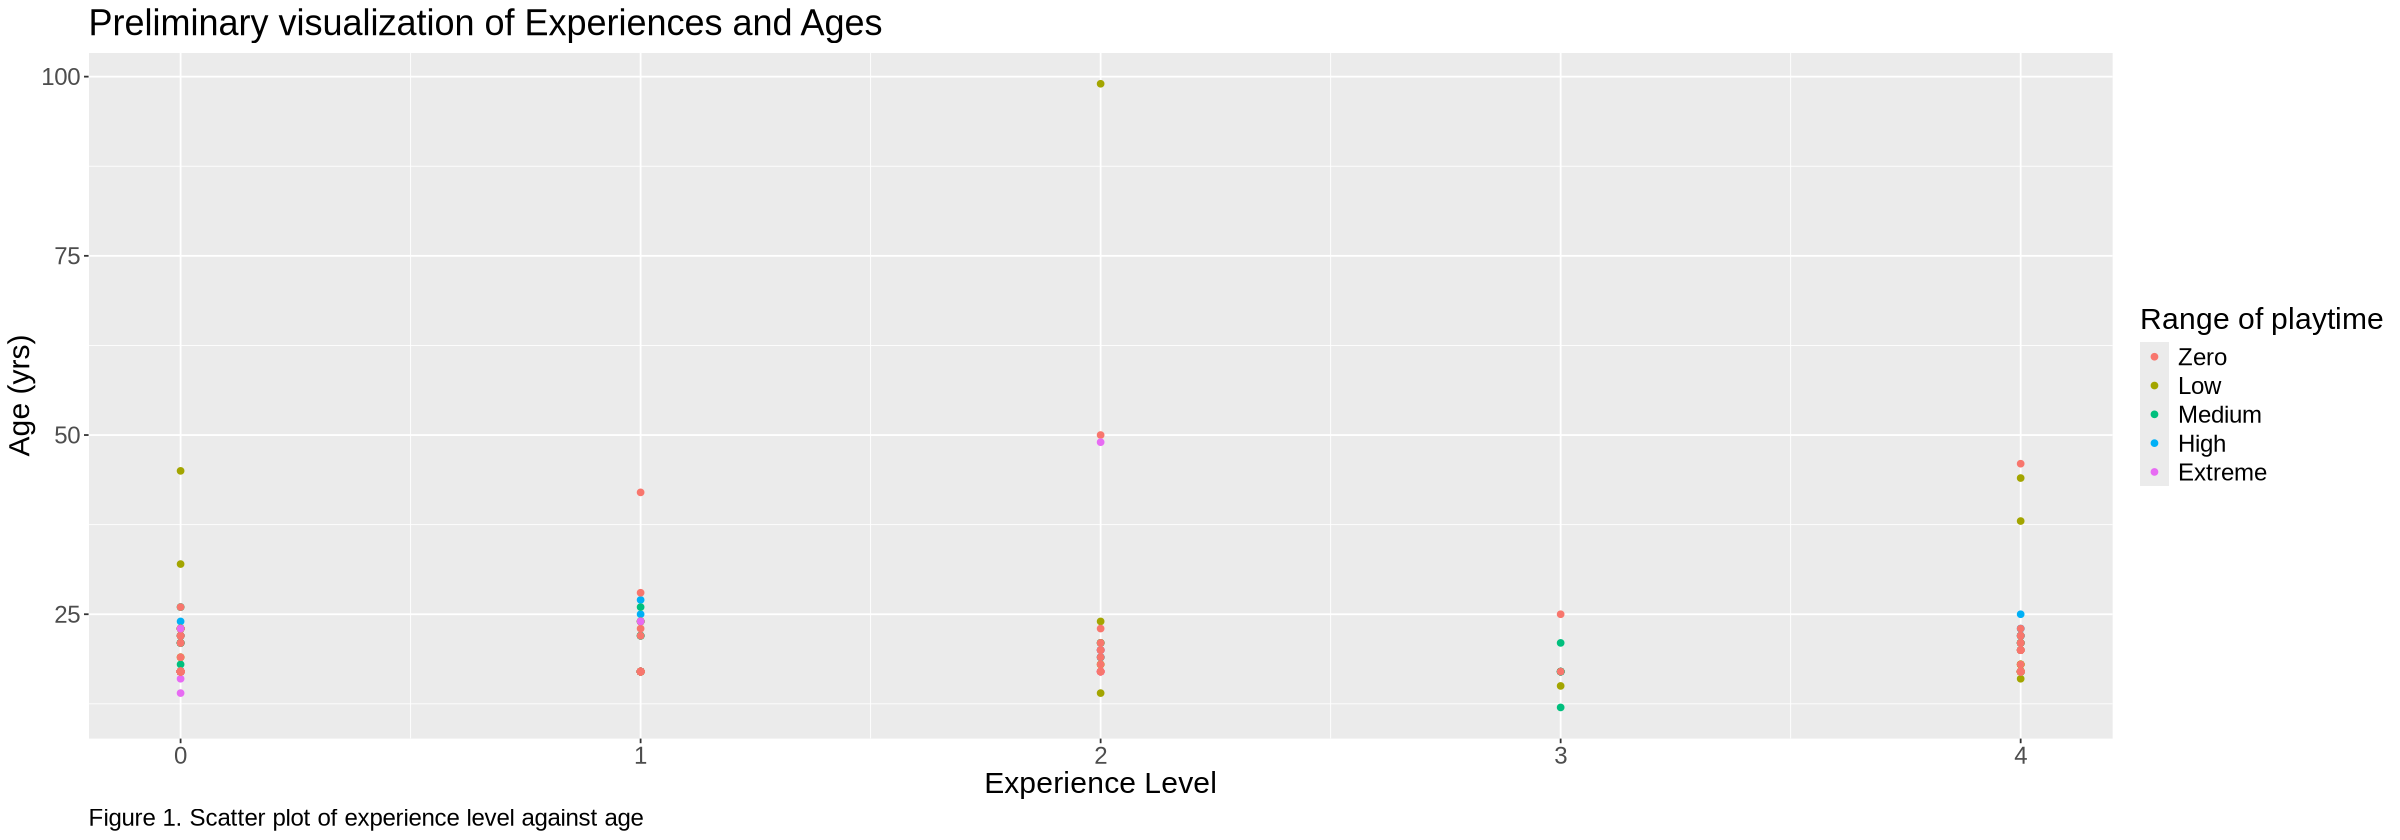

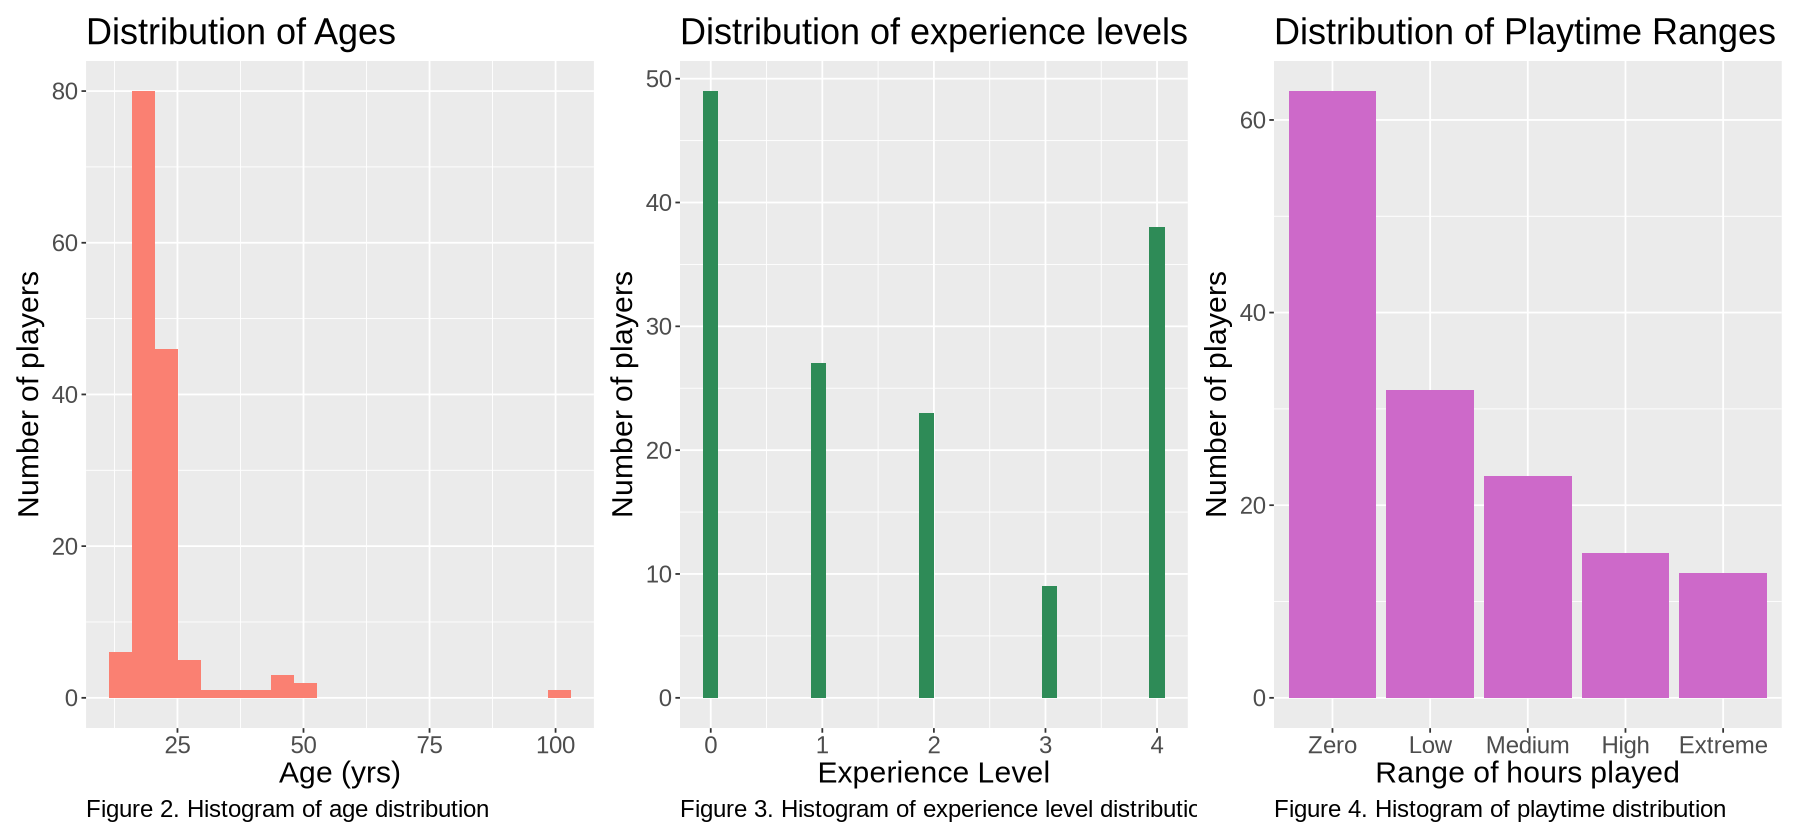

In [69]:
scatterplot <- data_training |>
            ggplot(aes(x=exp_level, y=age, colour=hours_range)) +
            geom_point() +
            labs(x="Experience Level", y="Age (yrs)", color="Range of playtime", caption = "Figure 1. Scatter plot of experience level against age", title = "Preliminary visualization of Experiences and Ages") +
            theme(text = element_text(size=18), plot.caption = element_text(hjust = 0))
scatterplot

library(patchwork)
options(repr.plot.width = 15, repr.plot.height = 7)

ages_plot <- data_training |>
        ggplot(aes(x=age))+
        geom_histogram(bins=20, fill="salmon") +
        labs(x="Age (yrs)", y = "Number of players", title = "Distribution of Ages", caption = "Figure 2. Histogram of age distribution")+
        theme(text = element_text(size = 18), plot.caption = element_text(hjust = 0)) 


exp_plot <- data_training |>
            ggplot(aes(x=exp_level)) +
            geom_histogram(fill="seagreen4") +
            labs(x="Experience Level", y="Number of players", title = "Distribution of experience levels", caption = "Figure 3. Histogram of experience level distribution") +
            theme(text = element_text(size=18), plot.caption = element_text(hjust = 0))

playtime_plot <- data_training |>
            group_by(hours_range) |>
            summarise(count = n()) |>
            ggplot(aes(x=hours_range, y=count)) +
            geom_bar(stat = "identity", fill="orchid3") +
            labs(x="Range of hours played", y="Number of players", title = "Distribution of Playtime Ranges", caption = "Figure 4. Histogram of playtime distribution") +
            theme(text = element_text(size=18), plot.caption = element_text(hjust = 0))

ages_plot + exp_plot + playtime_plot

Moving on, we can create the model as such. We decided upon a 75% training:testing split as well as a 5-fold cross validation as we have done in class.

neighbors,.metric,mean
<dbl>,<chr>,<dbl>
23,accuracy,0.4315887
25,accuracy,0.4315887
27,accuracy,0.4315887
29,accuracy,0.4315887
19,accuracy,0.4306958
21,accuracy,0.4306958
15,accuracy,0.4112993
17,accuracy,0.4112993
13,accuracy,0.3707204


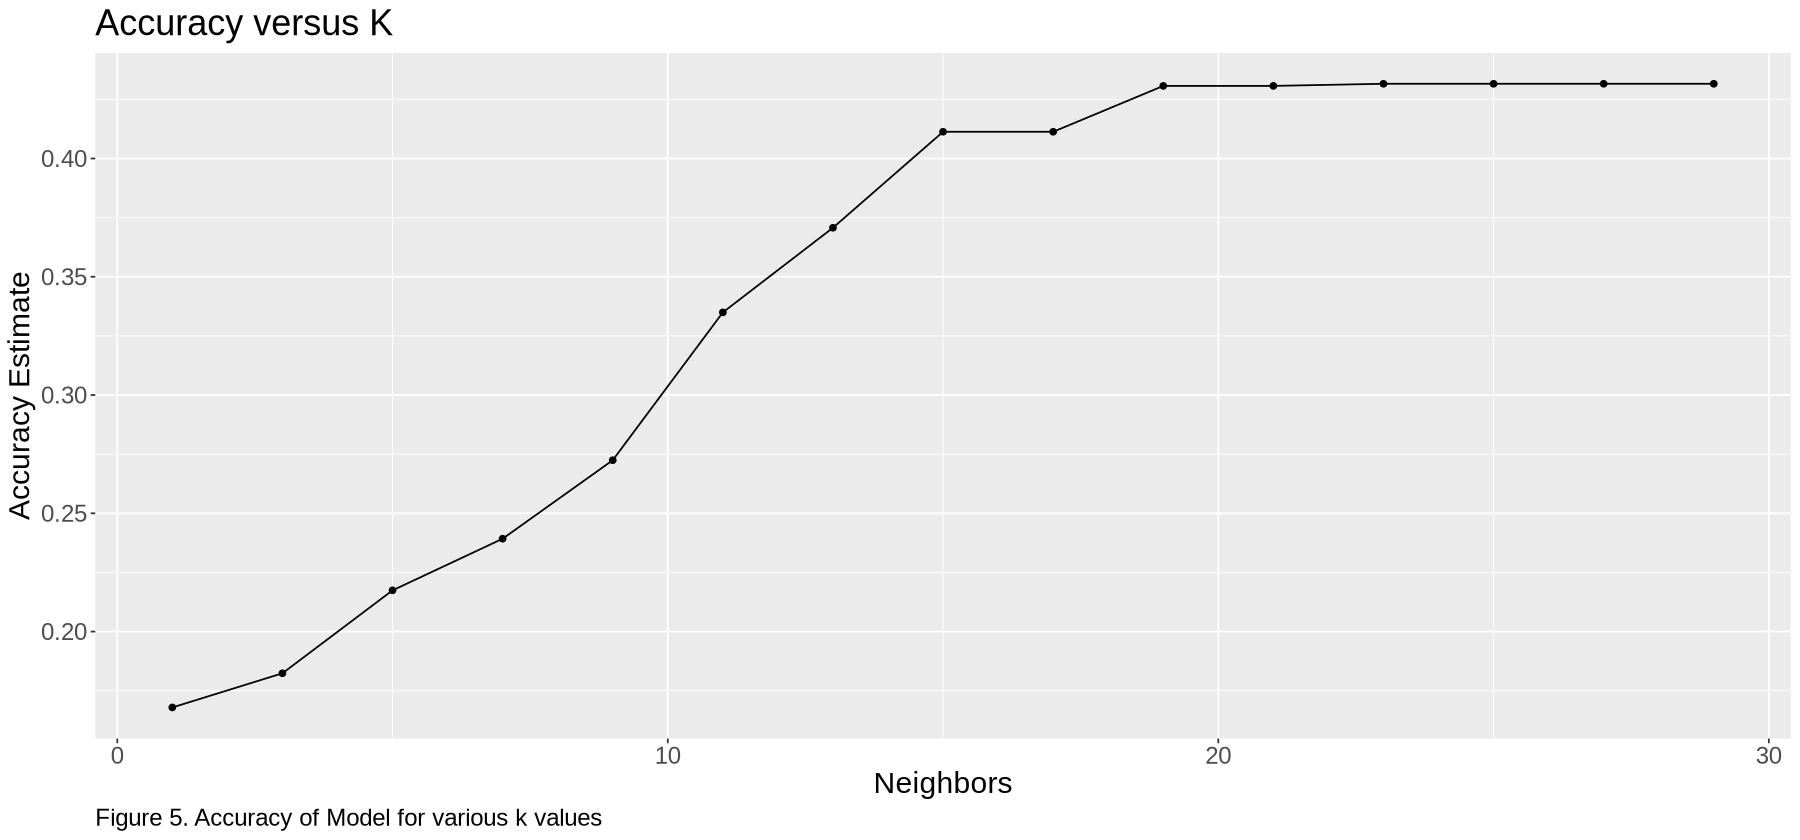

In [70]:
set.seed(12345)

player_recipe <- recipe(hours_range ~ age + exp_level, data= data_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

kvals <- tibble(neighbors = seq(from=1, to=30, by=2))
player_vfold <- vfold_cv(data_training, v=5, strata = hours_range)

player_results <- workflow() |>
            add_recipe(player_recipe) |>
            add_model(player_model) |>
            tune_grid(resamples = player_vfold, grid = kvals) |>
            collect_metrics() 
            
player_accuracy <- player_results |>
            select(neighbors, .metric, mean) |>
            filter(.metric == "accuracy") |>
            arrange(-mean) 

player_accuracy

cross_val_plot <- player_accuracy |>
            ggplot(aes(x=neighbors, y=mean))+
            geom_point()+
            geom_line()+
            labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy versus K", caption = "Figure 5. Accuracy of Model for various k values")  +
            theme(text = element_text(size=18), plot.caption = element_text(hjust = 0))
                  
cross_val_plot

The above plot displays the number of neighbors used for the model against accuracy, which we want to maximize (Fig. 5). It appears that the accuracy maxes out around k = 23 (though note that the means are still estimates so the actual best k value might be different!). This is the value we will choose to retrain our model.

In [71]:
player_model_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
            set_engine("kknn") |>
            set_mode("classification")

player_fit <- workflow() |>
        add_recipe(player_recipe) |>
        add_model(player_model_k) |>
        fit(data = data_training)

Now for the evaluation of accuracy based on the training set:

In [72]:
player_predictions <- predict(player_fit, data_testing)|>
                bind_cols(data_testing)

model_accuracy <- player_predictions |>
        metrics(truth = hours_range, estimate = .pred_class)|>
          filter(.metric == "accuracy") |>
          select(.estimate) |>
          pull()

print(paste(model_accuracy, "is the model's accuracy.")) 


[1] "0.44 is the model's accuracy."


Let's test the model on a new observation, to see if it works!

In [73]:
new_player <- tibble(age = 12, exp_level = 3)

player_predict <- predict(player_fit, new_player)
player_predict

.pred_class
<fct>
Low


It works! 

Now, to characterize which groups of people will give the highest play times, we will create new, fake datasets to test our model on. By running our data on these "fabricated" data sets, we will be able to gauge the combined characteristics of the players who will give high play times. We made a Google Sheets to make our fake data, and imported the file to this Jupyter Notebook. 

In [74]:
# Loading in the fake players data set

url <- "https://drive.google.com/uc?export=download&id=177BnvAy2DI-YJAGaoQucoAz0TQmxRZ6H"
fake_player_data <- read.csv(url)


# Filtering for experience level

fake_amateur<- fake_player_data |>
                filter(exp_level=='amateur')|>
                mutate(exp_level = 0)

fake_beginner<- fake_player_data|>
                filter(exp_level=='beginner')|>
                mutate(exp_level = 1)

fake_regular<- fake_player_data|>
                filter(exp_level=='regular')|>
                mutate(exp_level = 2)

fake_pro<- fake_player_data |>
            filter(exp_level=='pro')|>
                mutate(exp_level = 3)

fake_veteran <- fake_player_data |>
                filter(exp_level=='veteran')|>
                mutate(exp_level = 4)

fake_players <- rbind(fake_amateur, fake_beginner, fake_regular, fake_pro, fake_veteran) 

# Show the head and tail of our fake dataset for clarity

head(fake_players)
tail(fake_players)

,exp_level,age
,<dbl>,<int>
1,0,0
2,0,1
3,0,2
4,0,3
5,0,4
6,0,5


,exp_level,age
,<dbl>,<int>
500,4,95
501,4,96
502,4,97
503,4,98
504,4,99
505,4,100


In the above dataset, we made it so that there is one observation with their age ranging from 1-100 for all 4 of the experience levels. This way, after we run the model on this dataset, the output will tell us the predicted class of playtime hours (zero, low, medium, high, or extreme) for each age and experience level. If we know the class of playtime hours, we we then be able to pinpoint which experience and age combination will yield the highest play times.  

Below, we use our fake dataset to predict the classes of playtime hours; we also have graphed the results (Fig. 6).

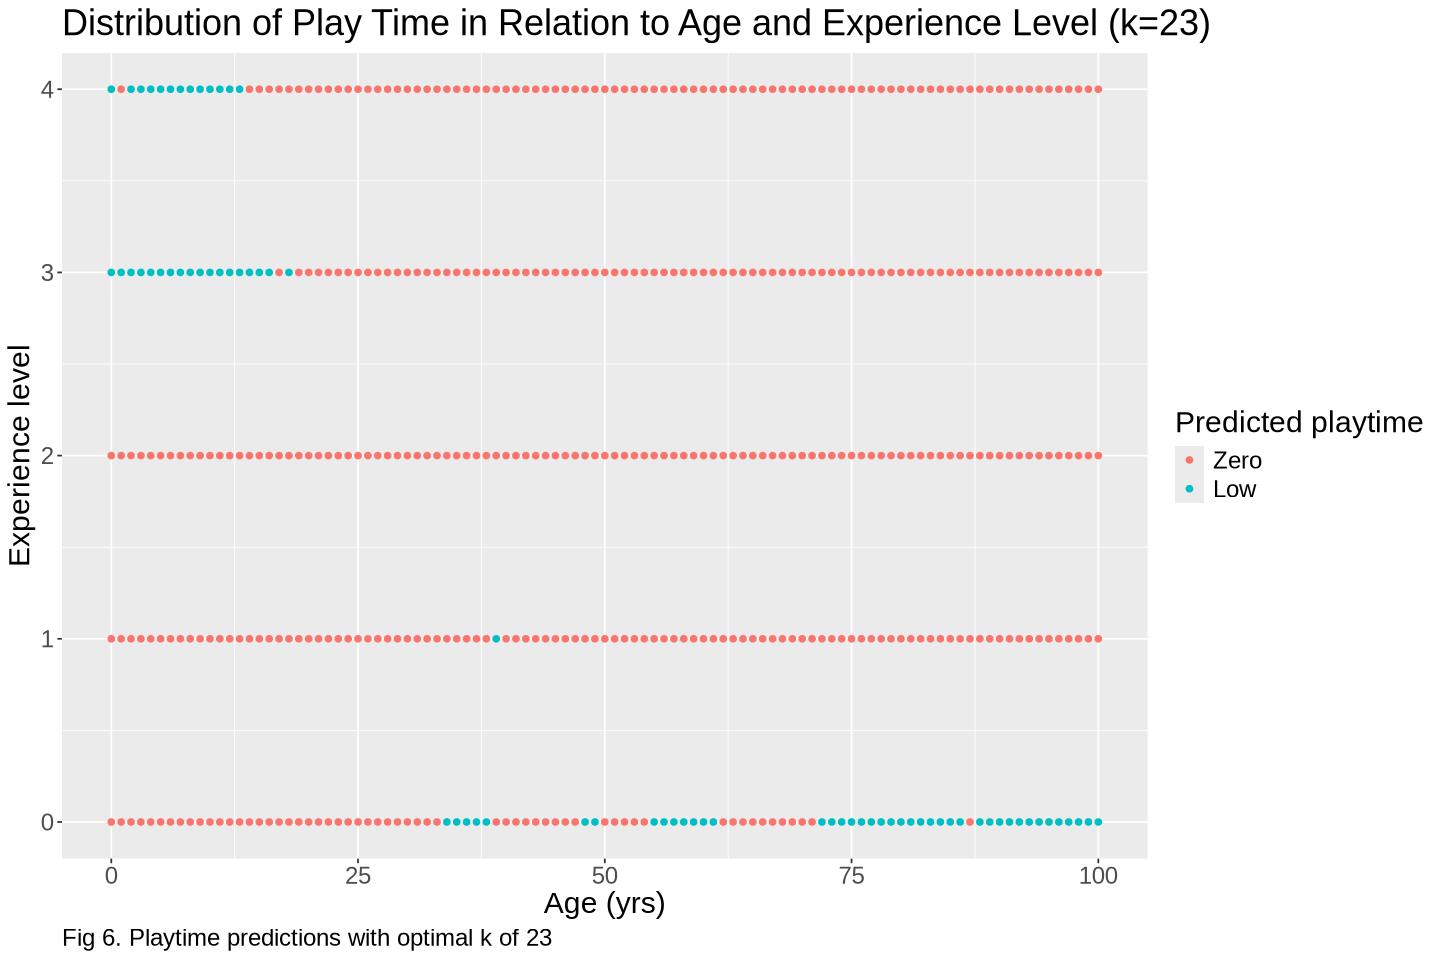

In [75]:
# Using the fake_players dataset to predict the classes of playtime hours. We can also graph the results!

fake_player_predictions <- predict(player_fit, fake_players)|>
                bind_cols(fake_players)

options(repr.plot.width=12, repr.plot.height=8)

fake_player_plot <- fake_player_predictions |>
                ggplot(aes(x=age, y=exp_level, color = .pred_class)) +
                geom_point() +
                labs(x="Age (yrs)", y= "Experience level", title = "Distribution of Play Time in Relation to Age and Experience Level (k=23)", 
                     color = "Predicted playtime", caption = "Fig 6. Playtime predictions with optimal k of 23")+
                theme(text = element_text(size=18), plot.caption = element_text(hjust = 0))
fake_player_plot

Using the above KNN classifier model, with 23 neighbors, there were a limited number of Medium playtime predictions and no High or Extreme predictions. Although this would decrease the accuracy, we can try to set k to a lower value to avoid potential overfitting. 
Here is code for an alternate model with a lower k, for example, k=9 (which would give accuracy of ~0.3 as calculated above). 
We decided on 9 neighbors because this was a reasonable intermediate that still maintained a reasonably high accuracy compared to the maximum but also yielded predictions beyond just low and zero.

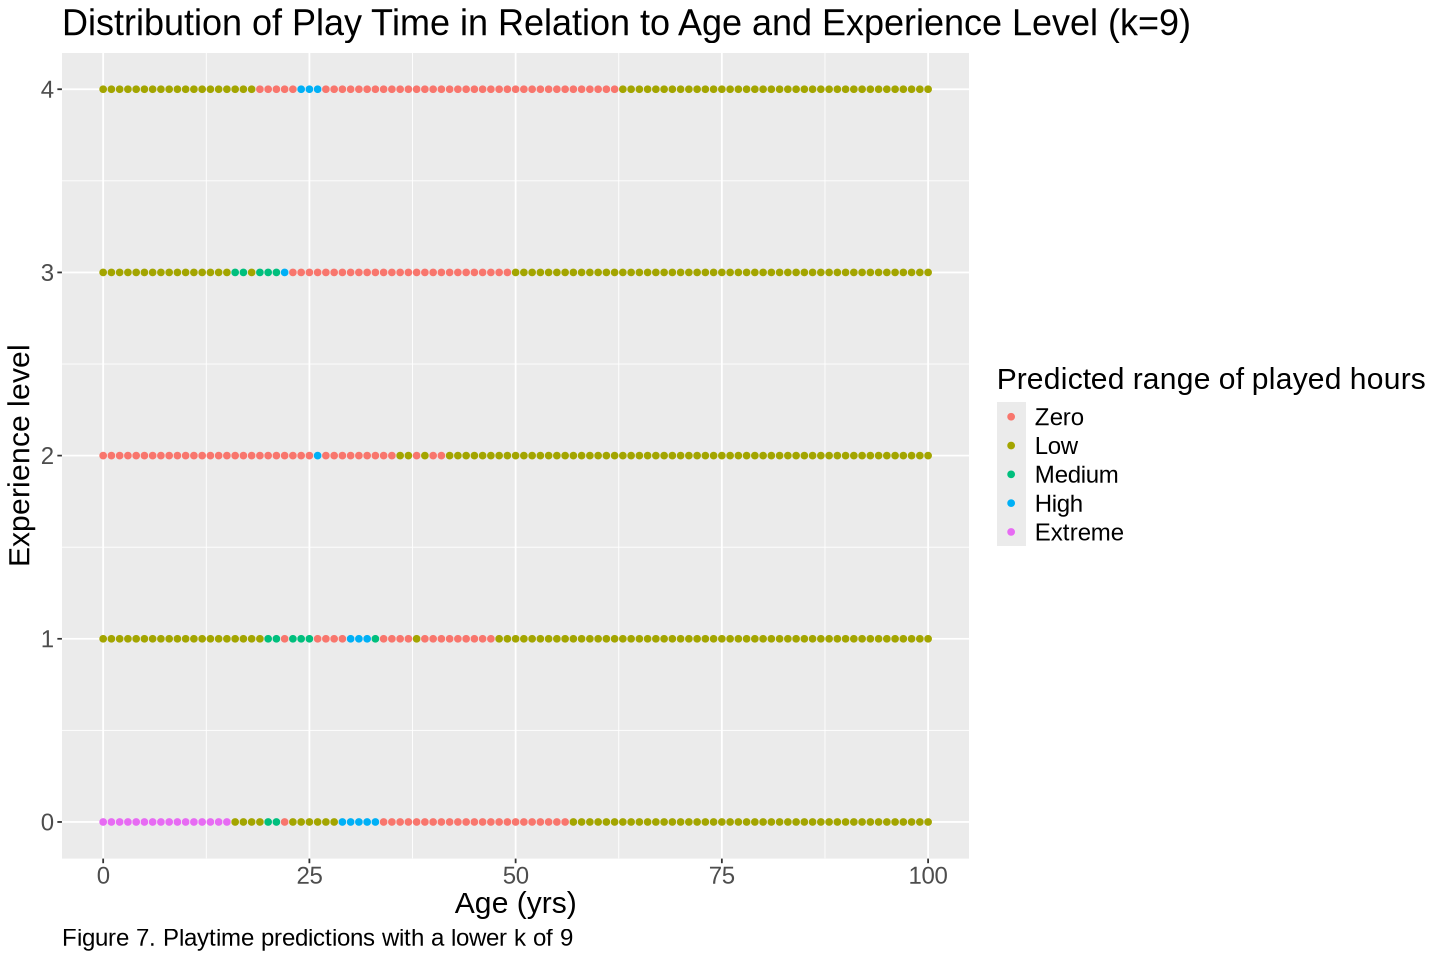

In [76]:
# Try k=9 instead to see if there is a wider range of play hour predictions

player_model_alternate <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")

player_fit_alternate <- workflow() |>
        add_recipe(player_recipe) |>
        add_model(player_model_alternate) |>
        fit(data = data_training)

predictions_alternate <- predict(player_fit_alternate, fake_players)|>
                bind_cols(fake_players)

options(repr.plot.width=12, repr.plot.height=8)
prediction_plot_alternate <- predictions_alternate |>
                ggplot(aes(x=age, y=exp_level, color = .pred_class)) +
                geom_point() +
                labs(x="Age (yrs)", y= "Experience level", color = "Predicted range of played hours", 
                title = "Distribution of Play Time in Relation to Age and Experience Level (k=9)", caption = "Figure 7. Playtime predictions with a lower k of 9") + 
                theme(text=element_text(size=18), plot.caption = element_text(hjust = 0))

prediction_plot_alternate

We see a much more detailed distribution of playtimes (Fig. 7), so we will use k = 9 for subsequent analysis. We can also create a bar plot to display the counts of each predicted playtime class for the experience levels (Fig. 8) as well as the ages (Fig. 9).

In [77]:

experience_counts <- predictions_alternate |>
            group_by(exp_level, .pred_class) |>
            summarize(number = n())

bar_experience <- experience_counts |>
                ggplot(aes(x=exp_level, y=number, fill = .pred_class)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x="Experience Level", y="Proportion of players", fill = "Predicted range of played hours", title = "Predicted Playtime for Each Experience Level", caption = "Figure 8. Stacked barplot displaying proportions of predicted classes for each experience level") +
                theme(text = element_text(size=16), plot.caption = element_text(hjust = 0))

age_counts <- predictions_alternate |>
            group_by(age, .pred_class) |>
            summarize(number = n())

bar_age <- age_counts |>
                ggplot(aes(x=age, y=number, fill = .pred_class)) +
                geom_bar(stat = "identity",position = "fill") +
                labs(x="Age (yrs)", y="Proportion of players", fill = "Predicted range of played hours", title = "Predicted Playtime for Each Age", caption = "Figure 9. Stacked barplot displaying proportions of predicted classes for each experience level") +
                theme(text = element_text(size=16), plot.caption = element_text(hjust = 0))


`summarise()` has grouped output by 'exp_level'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


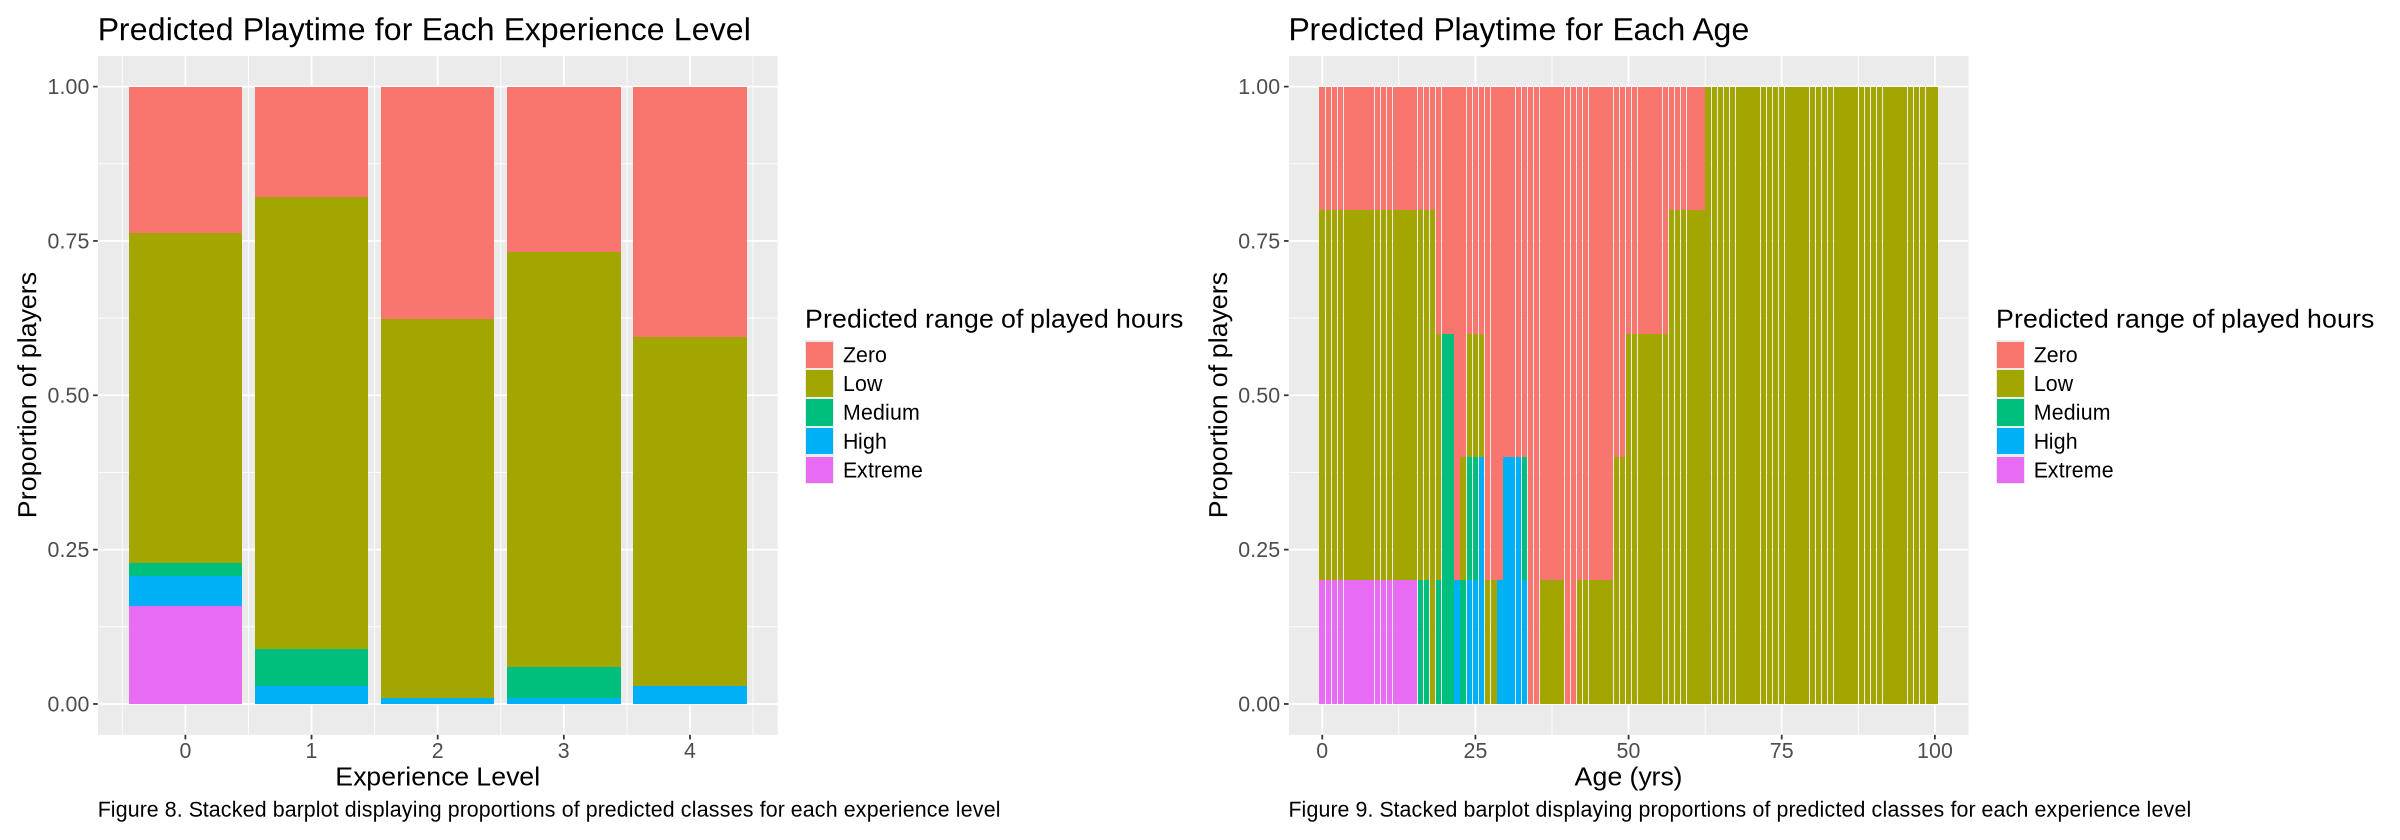

In [78]:
# View the plots side-by-side. 
options(repr.plot.width = 20, repr.plot.height = 7)
bar_experience+bar_age

## **Discussion**

**What did we find?**

Returning to our research question (*Based on age and experience, which group(s) of players should be targeted to maximize their contributed played hours?*), we found the following:

- Amateur players aged 0–15 are predicted to exhibit exceptionally high playtime, making them a *key demographic* to target for maximizing engagement.  
- Amateur players aged 29–33, as well as beginner players aged 30–33, are predicted to achieve high playtimes. 
- Players aged 34 and above, across all player categories, are expected to have minimal or zero playtime.  
- Most regular, professional, and veteran players, regardless of age, are anticipated to exhibit low or negligible playtime, with only a few exceptions observed around age 25.  
- Furthermore, considering that toddlers are unlikely to participate in video gaming and that the minimum age of a player in the dataset is 8, we conclude that the optimal target demographic for maximizing playtime consists of individuals aged 8 to 15.

In terms of the model:
- When using the optimal k value (maximized accuracy), the model accuracy was 0.4. 
- As briefly explained above, choosing k=23 led to the highest accuracy yet the model appeared to underfit and only predicted low or zero hours. This could have been due to the nature of the 'experience' level, which had originally been factor-type and thus only 5 numerical values were possible.
- A lower value of k should be chosen to be able to predict each playtime category. The choice of k is therefore somewhat arbitrary; in this analysis, we chose a k value that gave a reasonable accuracy (67% of the max) while being able to predict more than low/zero.



**Is this what we expected to find?** 

For the experience level, we didn't expect the amateurs to be predicted as yielding the highest play times. Intuitively, we thought that higher experienced players like pros and veterans would play more hours than less experienced players. However, in hindsight, since the pros and veterans have played the game a lot already, we thought that perhaps they would play the game on their own server rather than on the PLAICRAFT server. Also, a reason why amateurs might be contributing to more time could be because they are getting used to the game and figuring out how to play the game, and that process can be quite time-consuming.

However, for the ages, younger players were predicted to yield higher play times. These results were somewhat expected, since younger people tend to have more interest in the Minecraft game and are the typical target audience. Unexpectedly, the model predicts that older adults (50+) would play more than younger adults (35-50), as the proportions of zero predicted hours are highest in these young to middle aged adults. 

**Impact of findings**

Our findings can help the advertising team understand who and how to target players. For example, the designs for the advertising can be aimed less at adults and more at teenagers and amateur players. There can be marketing efforts and content updates to appeal to the targets. Since amateurs spend more time learning and exploring, designing beginner-friendly interfaces, tutorials, or incentives could improve their experience and retain their interest. Furthermore, the unexpectedly low playtimes for professionals and veterans indicate a potential shift in their gaming habits, such as favouring other servers or games. This could signal a need to investigate how to retain these experienced players.

**What future questions could this lead to?**

- Why do amateurs give the most predicted play time?
- What strategies can be applied, to increase the playtime among professional and veteran players?
- What features could be added to attract them back to PLAICRAFT (if the decrease in playtime is due to a shift to other video games)?
- What about Minecraft/PLAICRAFT appeals to younger audiences? Can those strategies be applied to older audiences? 
- Are there other variables that could impact the hours played (eg. gender, subscribe)? Can we incorporate these variables into the predictive model?